In [1]:
!pip -q install datasets transformers scipy tqdm --upgrade


**MS MARCO & SciFact & NQ**

This notebook presents an ablation study on DeRAG attacks using Differential Evolution (DE) under a controlled setting. Specifically, we evaluate how suffix length (`L ∈ {1..10}`) and retrieval depth (`Top-K ∈ {1, 10}`) affect the effectiveness of adversarial prompt suffixes.

###  Experiment Setup

- **Corpus**: Random sample of 1,000 documents per dataset
- **Queries**: 120 filtered questions per dataset (tokens ∈ [20, 500], must contain `?`)
- **Target Document**: Document ranked **800th** under baseline retrieval
- **Encoder**: `bert-base-uncased` (evaluated in `fp16` on GPU)
- **Suffix**: Appended at the end of the query, of length L ∈ [1, 10]
 

Each query is paired with one incorrect target passage from the 800th position. The goal is to use a DE-optimized suffix to **promote** that document into the **Top-K** positions. Suffixes are optimized using **hinge loss** over cosine similarity between query and document embeddings.

###  Evaluation Metrics
For each `(query, L, K)` setting, we report:
- **Suffix tokens** (`suffix`, `suffix_len`)
- **Final rank of target document** (`final_rank`)
- **Change in cosine similarity** (`Δcos`)
- **Change in nDCG** (`ΔnDCG@K`)
- **Success rate** (whether `rank ≤ K`)
- **Iteration count** (used by DE optimizer)

###  Output
Results are saved to:
```bash
exp_results/{dataset}/ablation/ablation_results.csv


In [8]:


import os, random, math, json, warnings, numpy as np, pandas as pd, torch, tqdm
from datasets     import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution
warnings.filterwarnings("ignore")

SEED             = 42
DEVICE           = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS, N_Q      = 1_000, 120
TAIL_MAX         = 10
RANK_TARGET      = 800
POP, MAXITER     = 20, 2_000
PATIENCE         = 20
BATCH_CLS        = 16          
DATASETS         = ["msmarco","fiqa","NQ"]   
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

tok  = BertTokenizer.from_pretrained("bert-base-uncased")
VOC  = tok.vocab_size


def enc(txts, dev):
    return tok(txts, padding="max_length", truncation=True,
               max_length=512, return_tensors="pt").to(dev)

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def dcg(rank:int)->float:
    return 1 / math.log2(rank + 1)

def is_good_q(t:str)->bool:
    return "?" in t and 20 < len(tok(t)["input_ids"])-2 < 500

def suffix_str(ids):            # pretty print suffix
    return " ".join(tok.convert_ids_to_tokens(ids))

def de_opt(ids, msk, CP, tgt_cls, L, topk):
    pos, bounds = list(range(512-L,512)), [(0,VOC-1)]*L
    def loss_from_cls(c):
        kth = torch.topk(cos_row(c,CP),topk).values[-1]
        sim = torch.nn.functional.cosine_similarity(c,tgt_cls)[0]
        return max(0., (kth-sim).item())
    def obj(v):
        v=[int(round(x)) for x in v]
        p,m=ids.clone(),msk.clone(); m[pos]=1
        for i,t in zip(pos,v): p[i]=t
        cls=bert(input_ids=p.unsqueeze(0),
                 attention_mask=m.unsqueeze(0)).last_hidden_state[:,0,:]
        return loss_from_cls(cls)
    best,stale=1e9,0
    def cb(xk,_):
        nonlocal best,stale
        cur=obj(xk)
        if cur<best: best,stale=cur,0
        else: stale+=1
        return cur==0 or stale>=PATIENCE
    res=differential_evolution(obj,bounds,popsize=POP,maxiter=MAXITER,
                               tol=0,polish=False,seed=SEED,callback=cb)
    suf=[int(round(x)) for x in res.x]
    p,m=ids.clone(),msk.clone(); m[pos]=1
    for i,t in zip(pos,suf): p[i]=t
    cls=bert(input_ids=p.unsqueeze(0),
             attention_mask=m.unsqueeze(0)).last_hidden_state[:,0,:]
    return suf,cls,res.nfev

def prepare(ds:str):
    corpus  = load_dataset(f"BeIR/{ds}", "corpus",  split="corpus")
    queries = load_dataset(f"BeIR/{ds}", "queries", split="queries")
    docs = random.sample(list(corpus), N_DOCS)

    pool = [q for q in queries if is_good_q(q["text"])]
    if len(pool) < N_Q:
        raise ValueError(f"{ds}: 問句僅 {len(pool)} 條，少於 120")
    qs = random.sample(pool, N_Q)

    cpu_bert = BertModel.from_pretrained("bert-base-uncased").eval().to("cpu")
    CLS=[]
    with torch.no_grad():
        for i in tqdm.tqdm(range(0,N_DOCS,BATCH_CLS), desc=f"{ds}-CLS"):
            batch = [d["text"] for d in docs[i:i+BATCH_CLS]]
            CLS.append(cpu_bert(**enc(batch,"cpu")).last_hidden_state[:,0,:])
    C_CLS = torch.cat(CLS)
    del cpu_bert; torch.cuda.empty_cache()

    return docs, qs, C_CLS

def run_ablation(ds:str):
    out_dir = f"exp_results/{ds}/ablation"
    os.makedirs(out_dir, exist_ok=True)

    docs, qs, C_CLS = prepare(ds)

    global bert
    bert = BertModel.from_pretrained("bert-base-uncased",
                                     torch_dtype=torch.float16
                                    ).to(DEVICE).eval()

    rec=[]
    for K in (1,10):
        for L in range(1, TAIL_MAX+1):
            for q in tqdm.tqdm(qs, desc=f"{ds}  K={K} L={L}"):
                qtxt = q["text"]
                ids,msk = enc([qtxt],DEVICE)["input_ids"][0], enc([qtxt],DEVICE)["attention_mask"][0]
                with torch.no_grad():
                    qcls = bert(**enc([qtxt],DEVICE)).last_hidden_state[:,0,:]

                sims = cos_row(qcls.cpu(), C_CLS)
                order = torch.argsort(sims, descending=True)
                tgt   = int(order[RANK_TARGET-1])
                tgt_txt = docs[tgt]["text"]
                if len(tok(tgt_txt)["input_ids"]) > 510: 
                    continue

                baseline_sim = sims[tgt].item()
                orig_top1    = docs[int(order[0])]["text"]
                tgt_cls      = C_CLS[tgt:tgt+1].to(DEVICE)
                CP           = C_CLS[[i for i in range(N_DOCS) if i != tgt]]

                suf, cls, it = de_opt(ids, msk, CP, tgt_cls, L, K)
                new_sims = cos_row(cls.cpu(), C_CLS)
                fr = (new_sims > new_sims[tgt]).sum().item() + 1

                rec.append(dict(dataset=ds, topK=K, L=L,
                                query=qtxt,
                                target_excerpt=tgt_txt[:120].replace("\n"," "),
                                orig_top1_excerpt=orig_top1[:120].replace("\n"," "),
                                suffix=suffix_str(suf),
                                suffix_len=len(suf),
                                suffix_token_ids=json.dumps(suf),
                                baseline_rank=RANK_TARGET,
                                final_rank=fr,
                                delta_rank=RANK_TARGET-fr,
                                delta_cos=new_sims[tgt].item()-baseline_sim,
                                delta_ndcg=dcg(fr)-dcg(RANK_TARGET),
                                success=int(fr<=K),
                                iter_used=it))
                torch.cuda.empty_cache()

    pd.DataFrame(rec).to_csv(f"{out_dir}/ablation_results.csv",
                             index=False, encoding="utf-8")
    print(f"✓ {ds} ablation FINISHED — rows = {len(rec)}")

if __name__ == "__main__":
    os.makedirs("exp_results", exist_ok=True)
    for ds in DATASETS:
        run_ablation(ds)
        torch.cuda.empty_cache()


msmarco  K=10 L=10: 100%|███████████████████████████████████████████████████████████| 120/120 [2:23:16<00:00, 71.64s/it]

✓ msmarco ablation 完成 — rows = 2400


#  DeRAG Loss Function Comparison

This repository evaluates the effectiveness of **Differential Evolution (DE)** optimized tail-patch attacks under different **loss objectives** (`hinge` vs. `cosine`) across four BEIR datasets.

##  Datasets

- **MS MARCO** (Open-domain QA)
- **FiQA** (Financial QA)
- **SciFact** (Scientific Fact Verification)
- **FEVER** (Fact Extraction and Verification)

## Experiment Setup

- **Corpus**: 1,000 documents per dataset
- **Queries**: 100 filtered questions per dataset  
  - Must contain a `?`
  - Token length ∈ [20, 500]
- **Target Document**: The **100th-ranked** document under baseline similarity (cosine).
- **Model**: `bert-base-uncased`
- **Device**: GPU with `float16` for inference
- **Optimization**: Differential Evolution (DE)
  - Population: 20
  - Max Iterations: 2,000
  - Suffix Length: `L = 5` tokens

##  Objective

For each `(query, target document)` pair, we use DE to generate a **5-token suffix** that is appended to the query to **promote the target document's rank**.

We compare two loss modes:

- `hinge`: Max-margin loss between target and top distractor
- `cos`: Cosine similarity loss with target document only

##  Evaluation Metrics

For each query and loss mode:

- `suffix` (token sequence)
- `suffix_len`
- `suffix_token_ids`
- `baseline_rank` (always 100)
- `final_rank`
- `delta_rank`
- `delta_cos`
- `delta_nDCG`
- `success` (whether final rank == 1)
- `iter_used` (optimizer steps)


In [46]:

import os
import random
import math
import json
import warnings

import numpy as np
import pandas as pd
import torch
import tqdm
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS, N_Q  = 1_000, 100         
TAIL_L       = 5                 
RANK_TARGET  = 100              
POP, MAXITER = 20, 2_000        
PATIENCE     = 20                
BATCH_CLS    = 16               

tok = BertTokenizer.from_pretrained("bert-base-uncased")
VOC = tok.vocab_size 

def enc(txts, dev):
    return tok(
        txts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(dev)

def get_ids_msk(text, dev):
    e = enc([text], dev)
    return e["input_ids"][0], e["attention_mask"][0]

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1
    )

def dcg(rank: int) -> float:
    return 1.0 / math.log2(rank + 1)

def is_good_q(text: str) -> bool:
   
    n = len(tok(text)["input_ids"]) - 2
    return (10 < n < 500)

def suffix_str(ids):
    return " ".join(tok.convert_ids_to_tokens(ids))

# ─────────────── DE 优化器 ───────────────
def de_opt(ids, msk, CP, tgt_cls, loss_mode="hinge"):

    L = TAIL_L
    pos = list(range(512 - L, 512))
    bounds = [(0, VOC - 1)] * L

    def loss_from_cls(c):
        # c: shape [1, dim]
        if loss_mode == "cos":
            # cos loss = - cosine_similarity(c, tgt_cls)
            return -(torch.nn.functional.cosine_similarity(c, tgt_cls)[0]).item()
        kth = torch.topk(cos_row(c, CP), 1).values[-1]
        sim = torch.nn.functional.cosine_similarity(c, tgt_cls)[0]
        return max(0.0, (kth - sim).item())

    def obj(v):
        v = [int(round(x)) for x in v]
        p, m = ids.clone(), msk.clone()
        for i, t in zip(pos, v):
            p[i] = t
        m[pos] = 1
        cls = bert(input_ids=p.unsqueeze(0),
                   attention_mask=m.unsqueeze(0)).last_hidden_state[:, 0, :]
        return loss_from_cls(cls)

    best, stale = 1e9, 0
    def cb(xk, _):
        nonlocal best, stale
        cur = obj(xk)
        if cur < best:
            best, stale = cur, 0
        else:
            stale += 1
        return (cur == 0) or (stale >= PATIENCE)

    res = differential_evolution(
        obj,
        bounds,
        popsize=POP,
        maxiter=MAXITER,
        tol=0,
        polish=False,
        seed=SEED,
        callback=cb
    )
    suf = [int(round(x)) for x in res.x]
    p, m = ids.clone(), msk.clone()
    m[pos] = 1
    for i, t in zip(pos, suf):
        p[i] = t
    cls = bert(input_ids=p.unsqueeze(0),
               attention_mask=m.unsqueeze(0)).last_hidden_state[:, 0, :]
    return suf, cls, res.nfev

def load_qrels_fever():
    qrels_all = load_dataset("BeIR/fever-qrels", split="train")
    # 动态探测字段：通常是 'query-id', 'corpus-id', 'score'
    sample = qrels_all[0]
    r_qid_key   = next((k for k in sample.keys() if "query" in k.lower()), None)
    r_doc_key   = next((k for k in sample.keys() if "corpus" in k.lower() or "doc" in k.lower()), None)
    r_score_key = next((k for k in sample.keys() if k.lower() in {"score","label","relevance"}), None)
    if not (r_qid_key and r_doc_key and r_score_key):
        raise RuntimeError("fever:No qrels。")
    pos_dict = {}
    for r in qrels_all:
        if int(r[r_score_key]) > 0:
            qid = str(r[r_qid_key])
            did = str(r[r_doc_key])
            pos_dict.setdefault(qid, []).append(did)
    if not pos_dict:
        raise RuntimeError("fever: qrels no ans！")
    return pos_dict

# ─────────────── 数据集准备 ───────────────
def prepare_fever():
    print("\n### Preparing FEVER ###")

    queries = load_dataset("BeIR/fever", "queries", split="queries")
    corpus  = load_dataset("BeIR/fever", "corpus",  split="corpus")
    pos_dict = load_qrels_fever()
    sample_q = queries[0]
    qid_key  = next((k for k in sample_q.keys() if "id" in k.lower()), None)
    text_key = next((k for k in sample_q.keys() if k.lower() in {"text","query","body"}), None)
    if not (qid_key and text_key):
        raise RuntimeError("fever: 无法检测到 queries 中的字段。")
    sample_d = corpus[0]
    doc_id_key   = next((k for k in sample_d.keys() if "id" in k.lower()), None)
    doc_text_key = next((k for k in sample_d.keys()
                         if "text" in k.lower() or "body" in k.lower() or "passage" in k.lower()), None)
    if not (doc_id_key and doc_text_key):
        raise RuntimeError("fever: 无法检测到 corpus 中的字段。")
    cand = [
        {"id": str(q[qid_key]), "text": q[text_key]}
        for q in queries
        if (str(q[qid_key]) in pos_dict) and isinstance(q.get(text_key), str) and is_good_q(q[text_key])
    ]
    if len(cand) == 0:
        raise RuntimeError("fever: no query！")
    if len(cand) < N_Q:
        qs = random.choices(cand, k=N_Q)
    else:
        qs = random.sample(cand, N_Q)

    pos_ids = { pos_dict[q["id"]][0] for q in qs }
    all_doc_ids = [str(d[doc_id_key]) for d in corpus]
    other_ids = [did for did in all_doc_ids if did not in pos_ids]
    if len(other_ids) < N_DOCS - len(pos_ids):
        raise RuntimeError(f"fever: 填充文档不足（需要 {N_DOCS - len(pos_ids)}, 只有 {len(other_ids)}）。")
    fillers = random.sample(other_ids, N_DOCS - len(pos_ids))
    sel_ids = list(pos_ids) + fillers
    id2text = { str(d[doc_id_key]): d[doc_text_key] for d in corpus }
    docs = [{"id": did, "text": id2text[did]} for did in sel_ids]
    pos_text = { did: id2text[did][:120].replace("\n", " ") for did in pos_ids }
    cpu_bert = BertModel.from_pretrained("bert-base-uncased").eval().to("cpu")
    CLS_list = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, N_DOCS, BATCH_CLS), desc="CLS-fever"):
            batch = docs[i : i + BATCH_CLS]
            batch_texts = [item["text"] for item in batch]
            out = cpu_bert(**enc(batch_texts, "cpu")).last_hidden_state[:, 0, :]
            CLS_list.append(out)
    C_CLS = torch.cat(CLS_list, dim=0)
    del cpu_bert
    torch.cuda.empty_cache()

    return docs, qs, pos_dict, pos_text, C_CLS

# ─────────────── 主实验函数 ───────────────
def run_loss_compare_fever():
    out_dir = "exp_results/loss_compare/fever"
    os.makedirs(out_dir, exist_ok=True)

    # 1. 组装数据
    docs, qs, pos_dict, pos_text, C_CLS = prepare_fever()

    # 用 GPU 加载 bert（用于对抗）
    global bert
    bert = BertModel.from_pretrained("bert-base-uncased",
                                     torch_dtype=torch.float16).to(DEVICE).eval()

    rec = []  
    for mode in ("hinge", "cos"):
        pbar = tqdm.tqdm(qs, desc=f"fever-{mode}")
        for q in pbar:
            qtxt = q["text"]
            qid  = q["id"]
            ids, msk = get_ids_msk(qtxt, DEVICE)
            with torch.no_grad():
                qcls = bert(**enc([qtxt], DEVICE)).last_hidden_state[:, 0, :]

            sims = cos_row(qcls.cpu(), C_CLS)
            order = torch.argsort(sims, descending=True)
            true_pos_id      = pos_dict[qid][0]
            true_pos_excerpt = pos_text[true_pos_id]
            tgt_idx       = int(order[RANK_TARGET - 1].item())
            tgt_id        = docs[tgt_idx]["id"]
            tgt_excerpt   = docs[tgt_idx]["text"][:120].replace("\n", " ")
            baseline_sim  = sims[tgt_idx].item()
            pos_rank    = None
            pos_excerpt = None
            tgt_cls = C_CLS[tgt_idx : tgt_idx + 1].to(DEVICE)
            CP = torch.cat([C_CLS[:tgt_idx], C_CLS[tgt_idx+1:]], dim=0)

            suf, cls_adv, iters = de_opt(ids, msk, CP, tgt_cls, loss_mode=mode)
            new_sims = cos_row(cls_adv.cpu(), C_CLS)
            fr = (new_sims > new_sims[tgt_idx]).sum().item() + 1
            entry = {
                "dataset":             "fever",
                "loss":                mode,
                "query":               qtxt,
                "orig_answer_id":      true_pos_id,
                "orig_answer_excerpt": true_pos_excerpt,
                "tgt_id":              tgt_id,
                "tgt_excerpt":         tgt_excerpt,
                "suffix":              suffix_str(suf),
                "suffix_len":          len(suf),
                "suffix_token_ids":    json.dumps(suf),
                "baseline_rank":       RANK_TARGET,
                "final_rank":          fr,
                "delta_rank":          RANK_TARGET - fr,
                "delta_cos":           new_sims[tgt_idx].item() - baseline_sim,
                "delta_ndcg":          dcg(fr) - dcg(RANK_TARGET),
                "success":             int(fr == 1),
                "iter_used":           iters,
                "pos_rank":            pos_rank,
                "pos_excerpt":         pos_excerpt,
            }
            rec.append(entry)

    df = pd.DataFrame(rec)
    df.to_csv(f"{out_dir}/loss_detail.csv", index=False, encoding="utf-8")

    agg = df.groupby("loss").agg(
        success_rate   = ("success",   "mean"),
        avg_iters      = ("iter_used", "mean"),
        avg_delta_rank = ("delta_rank","mean"),
        avg_delta_cos  = ("delta_cos", "mean"),
    ).reset_index()
    agg.to_csv(f"{out_dir}/loss_aggregate.csv", index=False, encoding="utf-8")

    h = agg.loc[agg.loss == "hinge", "success_rate"].values[0]
    c = agg.loc[agg.loss == "cos",   "success_rate"].values[0]
    print(f"✓ fever done  –  hinge success = {h:.2%},  cos success = {c:.2%}")
    del bert
    torch.cuda.empty_cache()

# ─────────────── 主入口 ───────────────
if __name__ == "__main__":
    os.makedirs("exp_results/loss_compare/fever", exist_ok=True)
    run_loss_compare_fever()



### Preparing FEVER ###


fever-cos: 100%|████████████████████████████████████████████████████████████████████| 100/100 [1:22:05<00:00, 49.26s/it]

✓ fever done  –  hinge success = 26.00%,  cos success = 1.00%


In [42]:
import os
import random
import math
import json
import warnings

import numpy as np
import pandas as pd
import torch
import tqdm
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS, N_Q  = 1_000, 100       
TAIL_L       = 5                 
RANK_TARGET  = 100               
POP, MAXITER = 20, 2_000         
PATIENCE     = 20                
BATCH_CLS    = 16               
tok = BertTokenizer.from_pretrained("bert-base-uncased")
VOC = tok.vocab_size 
def enc(txts, dev):

    return tok(
        txts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(dev)

def get_ids_msk(text, dev):
    e = enc([text], dev)
    return e["input_ids"][0], e["attention_mask"][0]

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1
    )

def dcg(rank: int) -> float:
    return 1.0 / math.log2(rank + 1)

def is_good_q(text: str) -> bool:
    if "?" not in text:
        return False
    n = len(tok(text)["input_ids"]) - 2
    return (15 < n < 500)

def suffix_str(ids):
    return " ".join(tok.convert_ids_to_tokens(ids))

def de_opt(ids, msk, CP, tgt_cls, loss_mode="hinge"):

    L = TAIL_L
    pos = list(range(512 - L, 512))
    bounds = [(0, VOC - 1)] * L

    def loss_from_cls(c):
        # c: shape [1, dim]
        if loss_mode == "cos":
            return -(torch.nn.functional.cosine_similarity(c, tgt_cls)[0]).item()
        kth = torch.topk(cos_row(c, CP), 1).values[-1]
        sim = torch.nn.functional.cosine_similarity(c, tgt_cls)[0]
        return max(0.0, (kth - sim).item())

    def obj(v):
        
        v = [int(round(x)) for x in v]
        p, m = ids.clone(), msk.clone()
        for i, t in zip(pos, v):
            p[i] = t
        m[pos] = 1
        cls = bert(input_ids=p.unsqueeze(0),
                   attention_mask=m.unsqueeze(0)).last_hidden_state[:, 0, :]
        return loss_from_cls(cls)

    best, stale = 1e9, 0
    def cb(xk, _):
        nonlocal best, stale
        cur = obj(xk)
        if cur < best:
            best, stale = cur, 0
        else:
            stale += 1
        return (cur == 0) or (stale >= PATIENCE)

    res = differential_evolution(
        obj,
        bounds,
        popsize=POP,
        maxiter=MAXITER,
        tol=0,
        polish=False,
        seed=SEED,
        callback=cb
    )
    suf = [int(round(x)) for x in res.x]
    p, m = ids.clone(), msk.clone()
    m[pos] = 1
    for i, t in zip(pos, suf):
        p[i] = t
    cls = bert(input_ids=p.unsqueeze(0),
               attention_mask=m.unsqueeze(0)).last_hidden_state[:, 0, :]
    return suf, cls, res.nfev

def load_qrels_fiqa():
    qrels_all = load_dataset("BeIR/fiqa-qrels")
    qrels = qrels_all["test"]
    sample = qrels[0]
    r_qid_key   = next((k for k in sample.keys() if "query" in k.lower()), None)
    r_doc_key   = next((k for k in sample.keys() if "corpus" in k.lower() or "doc" in k.lower()), None)
    r_score_key = next((k for k in sample.keys() if k.lower() in {"score","label","relevance"}), None)
    if not (r_qid_key and r_doc_key and r_score_key):
        raise RuntimeError("fiqa: NOT ACCEPT。")
    pos_dict = {}
    for r in qrels:
        if int(r[r_score_key]) > 0:
            qid = str(r[r_qid_key])
            did = str(r[r_doc_key])
            pos_dict.setdefault(qid, []).append(did)
    if not pos_dict:
        raise RuntimeError("fiqa: qrels NO！")
    return pos_dict

def prepare_fiqa():
    print("\n### Preparing FiQA-2018 ###")
    queries = load_dataset("BeIR/fiqa", "queries", split="queries")
    corpus  = load_dataset("BeIR/fiqa", "corpus",  split="corpus")
    pos_dict = load_qrels_fiqa()
    sample_q = queries[0]
    qid_key  = next((k for k in sample_q.keys() if "id" in k.lower()), None)
    text_key = next((k for k in sample_q.keys() if k.lower() in {"text","query","body"}), None)
    if not (qid_key and text_key):
        raise RuntimeError("fiqa: NO QUERY。")
    sample_d = corpus[0]
    doc_id_key   = next((k for k in sample_d.keys() if "id" in k.lower()), None)
    doc_text_key = next((k for k in sample_d.keys() 
                         if "text" in k.lower() or "body" in k.lower() or "passage" in k.lower()), None)
    if not (doc_id_key and doc_text_key):
        raise RuntimeError("fiqa: NO CORPUS。")
    cand = [
        {"id": str(q[qid_key]), "text": q[text_key]}
        for q in queries
        if (str(q[qid_key]) in pos_dict) and isinstance(q.get(text_key), str) and is_good_q(q[text_key])
    ]
    if len(cand) == 0:
        raise RuntimeError("fiqa: OUT OF query！")
    if len(cand) < N_Q:
        qs = random.choices(cand, k=N_Q)
    else:
        qs = random.sample(cand, N_Q)
    pos_ids = { pos_dict[q["id"]][0] for q in qs }
    all_doc_ids = [str(d[doc_id_key]) for d in corpus]
    other_ids = [did for did in all_doc_ids if did not in pos_ids]
    if len(other_ids) < N_DOCS - len(pos_ids):
        raise RuntimeError(f"fiqa: NO（,NEED {N_DOCS - len(pos_ids)}, ONLY {len(other_ids)}）。")
    fillers = random.sample(other_ids, N_DOCS - len(pos_ids))
    sel_ids = list(pos_ids) + fillers
    id2text = { str(d[doc_id_key]): d[doc_text_key] for d in corpus }
    docs = [{"id": did, "text": id2text[did]} for did in sel_ids]
    pos_text = { did: id2text[did][:120].replace("\n", " ") for did in pos_ids }
    cpu_bert = BertModel.from_pretrained("bert-base-uncased").eval().to("cpu")
    CLS_list = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, N_DOCS, BATCH_CLS), desc="CLS-fiqa"):
            batch = docs[i : i + BATCH_CLS]
            batch_texts = [item["text"] for item in batch]
            out = cpu_bert(**enc(batch_texts, "cpu")).last_hidden_state[:, 0, :]
            CLS_list.append(out)
    C_CLS = torch.cat(CLS_list, dim=0)
    del cpu_bert
    torch.cuda.empty_cache()

    return docs, qs, pos_dict, pos_text, C_CLS
def run_loss_compare_fiqa():
    out_dir = "exp_results/loss_compare/fiqa"
    os.makedirs(out_dir, exist_ok=True)

 
    docs, qs, pos_dict, pos_text, C_CLS = prepare_fiqa()

    global bert
    bert = BertModel.from_pretrained("bert-base-uncased",
                                     torch_dtype=torch.float16).to(DEVICE).eval()

    rec = [] 

    for mode in ("hinge", "cos"):
        pbar = tqdm.tqdm(qs, desc=f"fiqa-{mode}")
        for q in pbar:
            qtxt = q["text"]
            qid  = q["id"]

            ids, msk = get_ids_msk(qtxt, DEVICE)
            with torch.no_grad():
                qcls = bert(**enc([qtxt], DEVICE)).last_hidden_state[:, 0, :]

            sims = cos_row(qcls.cpu(), C_CLS)
            order = torch.argsort(sims, descending=True)

            true_pos_id      = pos_dict[qid][0]
            true_pos_excerpt = pos_text[true_pos_id]

            tgt_idx       = int(order[RANK_TARGET - 1].item())
            tgt_id        = docs[tgt_idx]["id"]
            tgt_excerpt   = docs[tgt_idx]["text"][:120].replace("\n", " ")
            baseline_sim  = sims[tgt_idx].item()
            pos_rank    = None
            pos_excerpt = None
            tgt_cls = C_CLS[tgt_idx : tgt_idx + 1].to(DEVICE)
            CP = torch.cat([C_CLS[:tgt_idx], C_CLS[tgt_idx+1:]], dim=0)

            suf, cls_adv, iters = de_opt(ids, msk, CP, tgt_cls, loss_mode=mode)
            new_sims = cos_row(cls_adv.cpu(), C_CLS)
            fr = (new_sims > new_sims[tgt_idx]).sum().item() + 1
            entry = {
                "dataset":            "fiqa",
                "loss":               mode,
                "query":              qtxt,

                "orig_answer_id":      true_pos_id,
                "orig_answer_excerpt": true_pos_excerpt,
                "tgt_id":             tgt_id,
                "tgt_excerpt":        tgt_excerpt,

                "suffix":             suffix_str(suf),
                "suffix_len":         len(suf),
                "suffix_token_ids":   json.dumps(suf),
                "baseline_rank":      RANK_TARGET,
                "final_rank":         fr,
                "delta_rank":         RANK_TARGET - fr,
                "delta_cos":          new_sims[tgt_idx].item() - baseline_sim,
                "delta_ndcg":         dcg(fr) - dcg(RANK_TARGET),
                "success":            int(fr == 1),
                "iter_used":          iters,
                "pos_rank":           pos_rank,
                "pos_excerpt":        pos_excerpt,
            }

            rec.append(entry)

    df = pd.DataFrame(rec)
    df.to_csv(f"{out_dir}/loss_detail.csv", index=False, encoding="utf-8")
    agg = df.groupby("loss").agg(
        success_rate   = ("success",   "mean"),
        avg_iters      = ("iter_used", "mean"),
        avg_delta_rank = ("delta_rank","mean"),
        avg_delta_cos  = ("delta_cos", "mean"),
    ).reset_index()
    agg.to_csv(f"{out_dir}/loss_aggregate.csv", index=False, encoding="utf-8")

    h = agg.loc[agg.loss == "hinge", "success_rate"].values[0]
    c = agg.loc[agg.loss == "cos",   "success_rate"].values[0]
    print(f"✓ fiqa done  –  hinge success = {h:.2%},  cos success = {c:.2%}")
    del bert
    torch.cuda.empty_cache()
if __name__ == "__main__":
    os.makedirs("exp_results/loss_compare/fiqa", exist_ok=True)
    run_loss_compare_fiqa()



### Preparing FiQA-2018 ###


fiqa-cos: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [1:09:47<00:00, 41.88s/it]

✓ fiqa done  –  hinge success = 23.00%,  cos success = 2.00%


In [ ]:

plt.figure(figsize=(8, 5))
for ds_name in FILES.keys():
    for topk, linestyle, marker in [(1, '-', 'o'), (10, '--', 's')]:
        sub = summary_df[
            (summary_df['Dataset'] == ds_name) &
            (summary_df['TopK'] == topk)
        ].sort_values('suffix_len')
        plt.plot(
            sub['suffix_len'],
            sub['mean_delta_rank'],
            label=f"{ds_name} Top-{topk}",
            color=COLORS[ds_name],
            linestyle=linestyle,
            marker=marker,
            linewidth=2
        )

plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)
ymin, ymax = plt.ylim()
plt.fill_betweenx([ymin, ymax], 4.5, 10, color='gray', alpha=0.15)
plt.text(5.2, ymax * 0.9, 'Marginal gains ≈ 0 for L ≥ 5', fontsize=9, color='gray')

plt.xlabel('Suffix Length (L)')
plt.ylabel('Mean ΔRank')
plt.title('Mean ΔRank vs. Suffix Length – MSMARCO/Fiqa/nq (Top-1 & Top-10)')
plt.xticks(range(1, 11))
plt.grid(alpha=0.3)
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()

plt.savefig('delta_rank.png', dpi=300)
plt.show()

plt.figure(figsize=(8, 5))
for ds_name in FILES.keys():
    for topk, linestyle, marker in [(1, '-', 'o'), (10, '--', 's')]:
        sub = summary_df[
            (summary_df['Dataset'] == ds_name) &
            (summary_df['TopK'] == topk)
        ].sort_values('suffix_len')
        plt.plot(
            sub['suffix_len'],
            sub['success_rate'],
            label=f"{ds_name} Top-{topk}",
            color=COLORS[ds_name],
            linestyle=linestyle,
            marker=marker,
            linewidth=2
        )

plt.xlabel('Suffix Length (L)')
plt.ylabel('Success Rate')
plt.title('Success Rate vs. Suffix Length – MSMARCO/Fiqa/nq (Top-1 & Top-10)')
plt.xticks(range(1, 11))
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig('success_rate.png', dpi=300)
plt.show()
plt.figure(figsize=(8, 5))
for ds_name in FILES.keys():
    for topk, linestyle, marker in [(1, '-', 'o'), (10, '--', 's')]:
        mg_df = marginal_dict[(ds_name, topk)]
        plt.plot(
            mg_df['suffix_len'],
            mg_df['marginal_gain'],
            label=f"{ds_name} Top-{topk}",
            color=COLORS[ds_name],
            linestyle=linestyle,
            marker=marker,
            linewidth=2
        )

plt.axhline(y=0, color='gray', linestyle='-', linewidth=1)
plt.axvline(x=5, color='red', linestyle='--', linewidth=1)
plt.text(5.2, plt.ylim()[1] * 0.8, 'L = 5 cutoff', color='red', fontsize=9)

plt.xlabel('Suffix Length (L)')
plt.ylabel('Marginal Gain (ΔRank difference)')
plt.title('Marginal Gain vs. Suffix Length – MSMARCO/Fiqa/nq (Top-1 & Top-10)')
plt.xticks(range(1, 11))
plt.grid(alpha=0.3)
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()

plt.savefig('marginal_gain.png', dpi=300)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
FILES = {
    'MSMARCO': 'exp_results/msmarco/ablation/ablation_results.csv',
    'Fiqa':    'exp_results/ablation/ablation_results.csv',
    'nq':      'exp_results/nq/ablation/ablation_results.csv'
}
COLORS = {
    'MSMARCO': 'tab:blue',
    'Fiqa':    'tab:orange',
    'nq':      'tab:green'
}
def load_and_truncate(file_path, dataset_name, topk_focus, keep_per_group=100):
    if not pathlib.Path(file_path).exists():
        raise FileNotFoundError(f"File not found: {file_path}")

    df = pd.read_csv(file_path)
    if 'topK' in df.columns:
        topk_col = 'topK'
    elif 'top_k' in df.columns:
        topk_col = 'top_k'
    else:
        raise KeyError(f"Cannot find 'topK' or 'top_k' column in {file_path}")

    df['Dataset'] = dataset_name
    df_trunc = (
        df
        .groupby([topk_col, 'suffix_len'], group_keys=False)
        .apply(lambda grp: grp.iloc[:keep_per_group])
        .reset_index(drop=True)
    )

    df_focus = df_trunc[df_trunc[topk_col] == topk_focus].copy()
    df_focus['TopK'] = topk_focus
    return df_focus
data_frames = []
for ds_name, path in FILES.items():
    for topk in [1, 10]:
        df_focus = load_and_truncate(path, ds_name, topk_focus=topk, keep_per_group=100)
        data_frames.append(df_focus)
combined = pd.concat(data_frames, ignore_index=True)

def compute_summary(df):
    summary = (
        df
        .groupby(['Dataset', 'TopK', 'suffix_len'], as_index=False)
        .agg(
            mean_delta_rank=('delta_rank', 'mean'),
            success_rate   =('success',    'mean'),
            mean_delta_cos =('delta_cos',  'mean'),
            mean_delta_ndcg=('delta_ndcg', 'mean')
        )
    )
    return summary

summary_df = compute_summary(combined)

def compute_marginal_gain(summary_df, metric_key):
    df = summary_df.copy().sort_values('suffix_len').reset_index(drop=True)
    gains = [np.nan] 
    for i in range(1, len(df)):
        gains.append(df.loc[i, metric_key] - df.loc[i-1, metric_key])
    df['marginal_gain'] = gains
    return df
marginal_dict = {}
for ds_name in FILES.keys():
    for topk in [1, 10]:
        sub = summary_df[
            (summary_df['Dataset'] == ds_name) &
            (summary_df['TopK'] == topk)
        ][['suffix_len', 'mean_delta_rank']].copy()
        mg = compute_marginal_gain(sub, 'mean_delta_rank')
        marginal_dict[(ds_name, topk)] = mg

plt.figure(figsize=(8, 5))
for ds_name in FILES.keys():
    for topk, linestyle, marker in [(1, '-', 'o'), (10, '--', 's')]:
        sub = summary_df[
            (summary_df['Dataset'] == ds_name) &
            (summary_df['TopK'] == topk)
        ].sort_values('suffix_len')
        plt.plot(
            sub['suffix_len'],
            sub['mean_delta_rank'],
            label=f"{ds_name} Top-{topk}",
            color=COLORS[ds_name],
            linestyle=linestyle,
            marker=marker,
            linewidth=2
        )

plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)
ymin, ymax = plt.ylim()
plt.fill_betweenx([ymin, ymax], 4.5, 10, color='gray', alpha=0.15)
plt.text(5.2, ymax * 0.9, 'Marginal gains ≈ 0 for L ≥ 5', fontsize=9, color='gray')

plt.xlabel('Suffix Length (L)')
plt.ylabel('Mean ΔRank')
plt.title('Mean ΔRank vs. Suffix Length – MSMARCO/Fiqa/nq (Top-1 & Top-10)')
plt.xticks(range(1, 11))
plt.grid(alpha=0.3)
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
for ds_name in FILES.keys():
    for topk, linestyle, marker in [(1, '-', 'o'), (10, '--', 's')]:
        sub = summary_df[
            (summary_df['Dataset'] == ds_name) &
            (summary_df['TopK'] == topk)
        ].sort_values('suffix_len')
        plt.plot(
            sub['suffix_len'],
            sub['success_rate'],
            label=f"{ds_name} Top-{topk}",
            color=COLORS[ds_name],
            linestyle=linestyle,
            marker=marker,
            linewidth=2
        )

plt.xlabel('Suffix Length (L)')
plt.ylabel('Success Rate')
plt.title('Success Rate vs. Suffix Length – MSMARCO/Fiqa/nq (Top-1 & Top-10)')
plt.xticks(range(1, 11))
plt.grid(alpha=0.3)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
for ds_name in FILES.keys():
    for topk, linestyle, marker in [(1, '-', 'o'), (10, '--', 's')]:
        mg_df = marginal_dict[(ds_name, topk)]
        plt.plot(
            mg_df['suffix_len'],
            mg_df['marginal_gain'],
            label=f"{ds_name} Top-{topk}",
            color=COLORS[ds_name],
            linestyle=linestyle,
            marker=marker,
            linewidth=2
        )

plt.axhline(y=0, color='gray', linestyle='-', linewidth=1)
plt.axvline(x=5, color='red', linestyle='--', linewidth=1)
plt.text(5.2, plt.ylim()[1] * 0.8, 'L = 5 cutoff', color='red', fontsize=9)

plt.xlabel('Suffix Length (L)')
plt.ylabel('Marginal Gain (ΔRank difference)')
plt.title('Marginal Gain vs. Suffix Length – MSMARCO/Fiqa/nq (Top-1 & Top-10)')
plt.xticks(range(1, 11))
plt.grid(alpha=0.3)
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Loss-comparison experiment  –  Hinge vs. Cosine (针对 SciFact)
--------------------------------------------------------------
Datasets  : SciFact （BEIR/scifact）
Corpus    : 1 000 docs · 100 queries（保证每条 query 至少有 1 个正例文档）
Target    : baseline rank = 100
Tail-patch suffix length = 5 tokens
Outputs   : exp_results/loss_compare/scifact/{loss_detail.csv, loss_aggregate.csv}
"""

import os
import random
import math
import json
import warnings

import numpy as np
import pandas as pd
import torch
import tqdm
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution

warnings.filterwarnings("ignore")

# ─────────────── 全局配置 ───────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS, N_Q  = 1_000, 100         # 1 000 篇文档（含每条 query 的首个正例），随机抽 100 条 query
TAIL_L       = 5                 # suffix 长度 = 5 tokens
RANK_TARGET  = 100               # baseline 排名第 100 的文档作为攻击目标
POP, MAXITER = 20, 2_000         # DE 的种群大小、最大迭代次数
PATIENCE     = 20                # DE callback 早停阈值
BATCH_CLS    = 16                # CPU-BERT 计算 CLS 时的 batch size

# 加载 BERT tokenizer
tok = BertTokenizer.from_pretrained("bert-base-uncased")
VOC = tok.vocab_size  # 词表大小，用于 DE 优化时的 token bound

# ─────────────── 辅助函数 ───────────────
def enc(txts, dev):
    """
    对一批文本 txts 进行 BERT 编码（padding & truncation），并返回 dict{'input_ids','attention_mask'}，
    其中所有 tensor 都被 .to(dev)。
    """
    return tok(
        txts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(dev)

def get_ids_msk(text, dev):
    """
    针对单条 text，返回 (input_ids, attention_mask)，每个 shape 都是 (512,)。
    """
    e = enc([text], dev)
    return e["input_ids"][0], e["attention_mask"][0]

def cos_row(x, Y):
    """
    给定单个 vector x (shape: [1, dim])，和一组 vectors Y (shape: [N, dim])，
    返回 x 与 Y 中每一行的 cosine similarity，结果是长度 N 的 tensor。
    """
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1
    )

def dcg(rank: int) -> float:
    """
    计算 DCG（Discounted Cumulative Gain）指标的基础函数：1/log2(rank+1)
    """
    return 1.0 / math.log2(rank + 1)

def is_good_q(text: str) -> bool:
    """
    过滤 query 的函数：只要 token 长度（扣去 [CLS] [SEP]）在 (10, 500) 之间即可。
    """
    n = len(tok(text)["input_ids"]) - 2
    return (10 < n < 500)

def suffix_str(ids):
    """
    给定一个 token id 列表 ids（例如 [2134, 765, 56, ...]），
    返回对应的 token string：“token1 token2 token3 ...”。
    """
    return " ".join(tok.convert_ids_to_tokens(ids))

# ─────────────── DE 优化器 ───────────────
def de_opt(ids, msk, CP, tgt_cls, loss_mode="hinge"):
    """
    对 single-query single-target 进行 Differential Evolution 优化，寻找 L=TAIL_L 个 token，
    使得对抗后的 query CLS (cls) 与 target_cls 之间满足 hinge 或 cos loss 最小。
    参数：
      - ids, msk：query 对应的 input_ids/attention_mask
      - CP：排除了目标文档在外的所有 doc CLS（shape: [N_DOCS-1, dim]），用于 hinge “取第 1 阈值”
      - tgt_cls：目标文档 CLS（shape: [1, dim]）
      - loss_mode： "hinge" 或 "cos"
    返回：
      - suf：长度 = L 的 token id 列表
      - cls：suffix 拼接后对抗 query 的 CLS embedding
      - res.nfev：DE 优化过程中的函数评估次数
    """
    L = TAIL_L
    pos = list(range(512 - L, 512))
    bounds = [(0, VOC - 1)] * L

    def loss_from_cls(c):
        # c: shape [1, dim]
        if loss_mode == "cos":
            # cos loss = - cosine_similarity(c, tgt_cls)
            return -(torch.nn.functional.cosine_similarity(c, tgt_cls)[0]).item()
        # hinge loss: kth = 最接近 c 的“其他文档”得分（top-1），sim = c 与 tgt_cls 的 cos
        kth = torch.topk(cos_row(c, CP), 1).values[-1]
        sim = torch.nn.functional.cosine_similarity(c, tgt_cls)[0]
        return max(0.0, (kth - sim).item())

    def obj(v):
        # v: 长度 L 的浮点列表（DE 内部传递过来）
        v = [int(round(x)) for x in v]
        p, m = ids.clone(), msk.clone()
        for i, t in zip(pos, v):
            p[i] = t
        m[pos] = 1
        cls = bert(input_ids=p.unsqueeze(0),
                   attention_mask=m.unsqueeze(0)).last_hidden_state[:, 0, :]
        return loss_from_cls(cls)

    best, stale = 1e9, 0
    def cb(xk, _):
        nonlocal best, stale
        cur = obj(xk)
        if cur < best:
            best, stale = cur, 0
        else:
            stale += 1
        return (cur == 0) or (stale >= PATIENCE)

    res = differential_evolution(
        obj,
        bounds,
        popsize=POP,
        maxiter=MAXITER,
        tol=0,
        polish=False,
        seed=SEED,
        callback=cb
    )
    suf = [int(round(x)) for x in res.x]

    # 用最优 suf 重新计算一次 CLS，作为返回值
    p, m = ids.clone(), msk.clone()
    m[pos] = 1
    for i, t in zip(pos, suf):
        p[i] = t
    cls = bert(input_ids=p.unsqueeze(0),
               attention_mask=m.unsqueeze(0)).last_hidden_state[:, 0, :]
    return suf, cls, res.nfev

# ─────────────── QRELS 加载 ───────────────
def load_qrels_scifact():
    """
    为 SciFact 设计的 qrels 加载。返回 pos_dict: { str(query_id) : [ str(doc_id), ... ] }。
    只保留 score > 0 的那部分。SciFact 的 qrels 存放在 “BeIR/scifact-qrels” 数据集中，使用 split="train"。
    """
    qrels_all = load_dataset("BeIR/scifact-qrels", split="train")
    # 动态探测字段：通常是 'query-id', 'corpus-id', 'score'
    sample = qrels_all[0]
    r_qid_key   = next((k for k in sample.keys() if "query" in k.lower()), None)
    r_doc_key   = next((k for k in sample.keys() if "corpus" in k.lower() or "doc" in k.lower()), None)
    r_score_key = next((k for k in sample.keys() if k.lower() in {"score","label","relevance"}), None)
    if not (r_qid_key and r_doc_key and r_score_key):
        raise RuntimeError("scifact: 无法检测到 qrels 字段。")
    pos_dict = {}
    for r in qrels_all:
        if int(r[r_score_key]) > 0:
            qid = str(r[r_qid_key])
            did = str(r[r_doc_key])
            pos_dict.setdefault(qid, []).append(did)
    if not pos_dict:
        raise RuntimeError("scifact: qrels 中没有任何正例！")
    return pos_dict

# ─────────────── 数据集准备 ───────────────
def prepare_scifact():
    """
    1. 加载 BEIR/scifact 的 queries, corpus, qrels；
    2. 从 qrels 构建 pos_dict；筛出 N_Q 条 is_good_q 的 query（且在 pos_dict 里必须有正例）；
    3. 构建 docs 列表：保证每条 query 的第一个正例都在 N_DOCS 篇里，再随机补足到 N_DOCS；
    4. 用 CPU 上的 BERT 计算 docs 的 CLS embedding → C_CLS。
    返回：
      - docs: [{"id": str_id, "text": str_text}, …]（长度 = N_DOCS）
      - qs  : [{"id": str_id, "text": str_text}, …]（长度 = N_Q）
      - pos_dict: { query_id: [doc_id1, …], … }
      - pos_text: { doc_id: doc_text[:120], … }  （保存每条 query 首个正例的前 120 字作为 excerpt）
      - C_CLS: shape = [N_DOCS, hidden_dim]，docs 对应的 CLS embedding
    """
    print("\n### Preparing SciFact ###")

    # ——— 1. 加载 queries / corpus / qrels ———
    queries = load_dataset("BeIR/scifact", "queries", split="queries")
    corpus  = load_dataset("BeIR/scifact", "corpus",  split="corpus")
    pos_dict = load_qrels_scifact()

    # 动态检测 queries 字段
    sample_q = queries[0]
    qid_key  = next((k for k in sample_q.keys() if "id" in k.lower()), None)
    text_key = next((k for k in sample_q.keys() if k.lower() in {"text","query","body"}), None)
    if not (qid_key and text_key):
        raise RuntimeError("scifact: 无法检测到 queries 中的字段。")

    # 动态检测 corpus 字段
    sample_d = corpus[0]
    doc_id_key   = next((k for k in sample_d.keys() if "id" in k.lower()), None)
    doc_text_key = next((k for k in sample_d.keys()
                         if "text" in k.lower() or "body" in k.lower() or "passage" in k.lower()), None)
    if not (doc_id_key and doc_text_key):
        raise RuntimeError("scifact: 无法检测到 corpus 中的字段。")

    # ——— 2. 筛选 N_Q 条 query ———
    cand = [
        {"id": str(q[qid_key]), "text": q[text_key]}
        for q in queries
        if (str(q[qid_key]) in pos_dict) and isinstance(q.get(text_key), str) and is_good_q(q[text_key])
    ]
    if len(cand) == 0:
        raise RuntimeError("scifact: 没有符合条件的 query！")
    if len(cand) < N_Q:
        print(f"⚠ 可选 query 只有 {len(cand)} 条，不足 {N_Q}，会重复采样。")
        qs = random.choices(cand, k=N_Q)
    else:
        qs = random.sample(cand, N_Q)

    # ——— 3. 构建 docs 列表，确保每条 query 的第一个正例都在 N_DOCS 篇里 ———
    pos_ids = { pos_dict[q["id"]][0] for q in qs }
    all_doc_ids = [str(d[doc_id_key]) for d in corpus]
    other_ids = [did for did in all_doc_ids if did not in pos_ids]
    if len(other_ids) < N_DOCS - len(pos_ids):
        raise RuntimeError(f"scifact: 填充文档不足（需要 {N_DOCS - len(pos_ids)}, 只有 {len(other_ids)}）。")
    fillers = random.sample(other_ids, N_DOCS - len(pos_ids))
    sel_ids = list(pos_ids) + fillers

    # 构建 docs 列表
    id2text = { str(d[doc_id_key]): d[doc_text_key] for d in corpus }
    docs = [{"id": did, "text": id2text[did]} for did in sel_ids]
    pos_text = { did: id2text[did][:120].replace("\n", " ") for did in pos_ids }

    # ——— 4. 用 CPU 上的 BERT 计算 docs 的 CLS embedding ———
    cpu_bert = BertModel.from_pretrained("bert-base-uncased").eval().to("cpu")
    CLS_list = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, N_DOCS, BATCH_CLS), desc="CLS-scifact"):
            batch = docs[i : i + BATCH_CLS]
            batch_texts = [item["text"] for item in batch]
            out = cpu_bert(**enc(batch_texts, "cpu")).last_hidden_state[:, 0, :]
            CLS_list.append(out)
    C_CLS = torch.cat(CLS_list, dim=0)
    del cpu_bert
    torch.cuda.empty_cache()

    return docs, qs, pos_dict, pos_text, C_CLS

# ─────────────── 主实验函数 ───────────────
def run_loss_compare_scifact():
    """
    1. 调用 prepare_scifact() 组装好 docs、qs、pos_dict、pos_text、C_CLS；
    2. 对每条 query，先算真正正例作为 orig_top1，再算 baseline rank=100 文档信息，
       然后用 hinge/cos 两种 loss mode 对该目标文档做 suffix_5 攻击，
       收集记录并输出到 CSV。
    """
    out_dir = "exp_results/loss_compare/scifact"
    os.makedirs(out_dir, exist_ok=True)

    # 1. 组装数据
    docs, qs, pos_dict, pos_text, C_CLS = prepare_scifact()

    # 用 GPU 加载 bert（用于对抗）
    global bert
    bert = BertModel.from_pretrained("bert-base-uncased",
                                     torch_dtype=torch.float16).to(DEVICE).eval()

    rec = []  # 存放所有 query + 细节的 list

    # 2. 对每条 query，用 hinge + cos 两种 loss mode 分别跑一遍
    for mode in ("hinge", "cos"):
        pbar = tqdm.tqdm(qs, desc=f"scifact-{mode}")
        for q in pbar:
            qtxt = q["text"]
            qid  = q["id"]

            # 2.1 把 query 编码
            ids, msk = get_ids_msk(qtxt, DEVICE)
            with torch.no_grad():
                qcls = bert(**enc([qtxt], DEVICE)).last_hidden_state[:, 0, :]

            # 2.2 计算原始与所有 docs 的相似度，得到排序
            sims = cos_row(qcls.cpu(), C_CLS)
            order = torch.argsort(sims, descending=True)

            # —— 抓取“真正正例”信息，作为 orig_top1 —— 
            true_pos_id      = pos_dict[qid][0]
            true_pos_excerpt = pos_text[true_pos_id]

            # —— 抓取“baseline Rank=100”目标文档信息 —— 
            tgt_idx       = int(order[RANK_TARGET - 1].item())
            tgt_id        = docs[tgt_idx]["id"]
            tgt_excerpt   = docs[tgt_idx]["text"][:120].replace("\n", " ")
            baseline_sim  = sims[tgt_idx].item()

            # 不需要单独输出 pos_rank/pos_excerpt，这里统一设 None
            pos_rank    = None
            pos_excerpt = None

            # —— 对第 100 名目标文档做 suffix 攻击 —— 
            tgt_cls = C_CLS[tgt_idx : tgt_idx + 1].to(DEVICE)
            CP = torch.cat([C_CLS[:tgt_idx], C_CLS[tgt_idx+1:]], dim=0)

            suf, cls_adv, iters = de_opt(ids, msk, CP, tgt_cls, loss_mode=mode)
            new_sims = cos_row(cls_adv.cpu(), C_CLS)
            fr = (new_sims > new_sims[tgt_idx]).sum().item() + 1

            # —— 记录这一条 query + mode 的所有字段 —— 
            entry = {
                "dataset":             "scifact",
                "loss":                mode,
                "query":               qtxt,

                # 原本的“真正正例”直接当成 orig_top1
                "orig_answer_id":      true_pos_id,
                "orig_answer_excerpt": true_pos_excerpt,

                # baseline Rank=100
                "tgt_id":              tgt_id,
                "tgt_excerpt":         tgt_excerpt,

                # 对抗 patch 细节
                "suffix":              suffix_str(suf),
                "suffix_len":          len(suf),
                "suffix_token_ids":    json.dumps(suf),

                # ranking 变化
                "baseline_rank":       RANK_TARGET,
                "final_rank":          fr,
                "delta_rank":          RANK_TARGET - fr,
                "delta_cos":           new_sims[tgt_idx].item() - baseline_sim,
                "delta_ndcg":          dcg(fr) - dcg(RANK_TARGET),
                "success":             int(fr == 1),
                "iter_used":           iters,

                # 统一留 None
                "pos_rank":            pos_rank,
                "pos_excerpt":         pos_excerpt,
            }
            rec.append(entry)

    # 3. 写出 loss_detail.csv
    df = pd.DataFrame(rec)
    df.to_csv(f"{out_dir}/loss_detail.csv", index=False, encoding="utf-8")

    # 4. 聚合输出 loss_aggregate.csv
    agg = df.groupby("loss").agg(
        success_rate   = ("success",   "mean"),
        avg_iters      = ("iter_used", "mean"),
        avg_delta_rank = ("delta_rank","mean"),
        avg_delta_cos  = ("delta_cos", "mean"),
    ).reset_index()
    agg.to_csv(f"{out_dir}/loss_aggregate.csv", index=False, encoding="utf-8")

    h = agg.loc[agg.loss == "hinge", "success_rate"].values[0]
    c = agg.loc[agg.loss == "cos",   "success_rate"].values[0]
    print(f"✓ scifact done  –  hinge success = {h:.2%},  cos success = {c:.2%}")

    # 释放显存
    del bert
    torch.cuda.empty_cache()

# ─────────────── 主入口 ───────────────
if __name__ == "__main__":
    os.makedirs("exp_results/loss_compare/scifact", exist_ok=True)
    run_loss_compare_scifact()


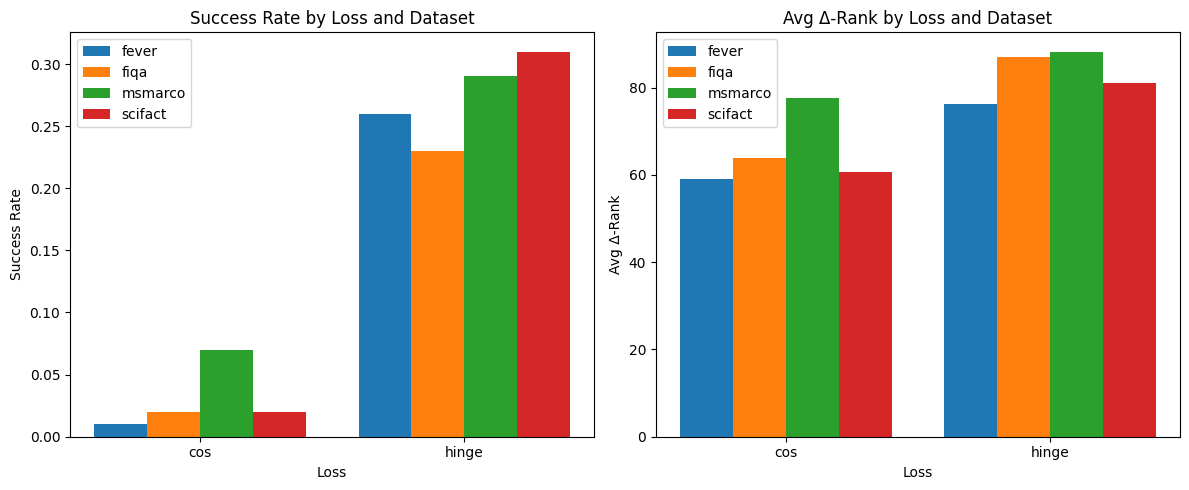


=== 四个数据集对比表格 ===

dataset  cos_avg_delta_cos  hinge_avg_delta_cos  cos_avg_delta_rank  hinge_avg_delta_rank  cos_avg_iters  hinge_avg_iters  cos_success_rate  hinge_success_rate
  fever             0.0686              -0.0273             59.0400               76.2600      4425.0000        3615.0000            0.0100              0.2600
   fiqa             0.0422              -0.0092             63.9200               86.9900      4274.0000        3743.0000            0.0200              0.2300
msmarco             0.0634               0.0208             77.6300               88.2500      4346.0000        3499.0000            0.0700              0.2900
scifact             0.0577              -0.0203             60.6700               80.9400      4624.0000        3466.0000            0.0200              0.3100


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths to loss_aggregate.csv for different datasets
paths = {
    'fever':  'exp_results/loss_compare/fever/loss_aggregate.csv',
    'scifact':'exp_results/loss_compare/scifact/loss_aggregate.csv',
    'msmarco':'exp_results/loss_compare/msmarco/loss_aggregate.csv',
    'fiqa':   'exp_results/loss_compare/fiqa/loss_aggregate.csv',
}

# 1) 读取并合并所有可用的 loss_aggregate.csv
dfs = []
for ds, path in paths.items():
    try:
        df = pd.read_csv(path)
        df['dataset'] = ds
        dfs.append(df)
    except FileNotFoundError:
        pass  # 如果某个数据集的文件不存在，就跳过

if not dfs:
    raise RuntimeError("找不到任何 loss_aggregate.csv，请检查路径是否正确。")

combined = pd.concat(dfs, ignore_index=True)

# 2) 构建两个 pivot tables
#    - 一个针对 success_rate：行=index=loss, 列=dataset, 值=success_rate
#    - 一个针对 avg_delta_rank：行=index=loss, 列=dataset, 值=avg_delta_rank
pivot_sr = combined.pivot(index='loss', columns='dataset', values='success_rate')
pivot_dr = combined.pivot(index='loss', columns='dataset', values='avg_delta_rank')

# 3) 确定 loss types & datasets 顺序
losses = pivot_sr.index.tolist()         # e.g. ['hinge', 'cos']
datasets = pivot_sr.columns.tolist()      # e.g. ['fever','scifact','msmarco','fiqa']

x = np.arange(len(losses))
width = 0.8 / len(datasets)  # 每个 bar 的宽度

# 4) 绘制两个并排子图：左边是 Success Rate，右边是 Avg Delta Rank
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# —— 左：Success Rate by Loss & Dataset —— 
for i, ds in enumerate(datasets):
    axes[0].bar(x + i*width, pivot_sr[ds], width, label=ds)

axes[0].set_xticks(x + width * (len(datasets)-1) / 2)
axes[0].set_xticklabels(losses)
axes[0].set_xlabel("Loss")
axes[0].set_ylabel("Success Rate")
axes[0].set_title("Success Rate by Loss and Dataset")
axes[0].legend()

# —— 右：Avg Delta Rank by Loss & Dataset —— 
for i, ds in enumerate(datasets):
    axes[1].bar(x + i*width, pivot_dr[ds], width, label=ds)

axes[1].set_xticks(x + width * (len(datasets)-1) / 2)
axes[1].set_xticklabels(losses)
axes[1].set_xlabel("Loss")
axes[1].set_ylabel("Avg Δ-Rank")
axes[1].set_title("Avg Δ-Rank by Loss and Dataset")
axes[1].legend()

plt.tight_layout()
plt.show()

# 1) 读取每个数据集的 loss_aggregate.csv，并将其重塑到同一个表格中
records = []
for ds, path in paths.items():
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        records.append({
            'dataset':          ds,
            'loss':             row['loss'],
            'success_rate':     row['success_rate'],
            'avg_delta_rank':   row['avg_delta_rank'],
            'avg_iters':        row['avg_iters'],
            'avg_delta_cos':    row['avg_delta_cos']
        })

combined = pd.DataFrame.from_records(records)

# 2) 将表格重塑为“dataset 为行，loss+指标 为列”的格式
pivot_table = combined.pivot_table(
    index='dataset',
    columns='loss',
    values=['success_rate', 'avg_delta_rank', 'avg_iters', 'avg_delta_cos']
)

# 3) 重新命名列：把多级列合并成单级，例如 'success_rate','hinge' → 'hinge_success_rate'
pivot_table.columns = [
    f"{loss}_{metric}" 
    for metric, loss in pivot_table.columns
]
pivot_table = pivot_table.reset_index()

# 4) 直接打印 DataFrame
print("\n=== 四个数据集对比表格 ===\n")
print(pivot_table.to_string(index=False, float_format="%.4f"))

In [59]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os, json, math, random, warnings, numpy as np, pandas as pd, torch, tqdm, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution
warnings.filterwarnings("ignore")

SEED           = 42
DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"
N_DOCS         = 1_000
RANK_TARGET    = 100
TAIL_L         = 5
GROUP_RANGE    = range(1, 21)
N_REPEAT       = 10
POP            = 20
MAXITER        = 2_000
PATIENCE       = 20

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
tok = BertTokenizer.from_pretrained("bert-base-uncased")
VOC = tok.vocab_size

def enc(txts, dev):
    return tok(txts, padding="max_length", truncation=True, max_length=512, return_tensors="pt").to(dev)

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def is_good_q(t):
    return "?" in t and 20 < len(tok(t)["input_ids"]) - 2 < 500

def suffix_str(ids):
    return " ".join(tok.convert_ids_to_tokens(ids))

def detect_key(sample, keys):
    for k in sample:
        low = k.lower()
        for tgt in keys:
            if tgt in low:
                return k
    return list(sample.keys())[0]

def prepare_corpus():
    corpus_ds = load_dataset("BeIR/fiqa", "corpus", split="corpus")
    docs = random.sample(list(corpus_ds), N_DOCS)
    cpu_bert = BertModel.from_pretrained("bert-base-uncased").eval().to("cpu")
    CLS = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, N_DOCS, 32), desc="CLS"):
            CLS.append(cpu_bert(**enc([d["text"] for d in docs[i:i+32]], "cpu")).last_hidden_state[:, 0, :])
    C_CLS = torch.cat(CLS)
    q_ds = load_dataset("BeIR/fiqa", "queries", split="queries")
    qid_key = detect_key(q_ds[0], {"id", "qid", "query_id", "number"})
    txt_key = detect_key(q_ds[0], {"text", "query", "body"})
    pool = [{"id": q[qid_key], "text": q[txt_key]} for q in q_ds if is_good_q(q[txt_key])]
    return docs, C_CLS, pool

docs, C_CLS, pool = prepare_corpus()
bert = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16).to(DEVICE).eval()

def optimise_suffix(group_q, trace_csv):
    pos = list(range(512 - TAIL_L, 512))
    bounds = [(0, VOC - 1)] * TAIL_L
    infos = []
    for q in group_q:
        e = enc([q["text"]], DEVICE)
        ids, msk = e["input_ids"][0], e["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**e).last_hidden_state[:, 0, :]
        sims = cos_row(qcls.cpu(), C_CLS)
        tgt_idx = torch.argsort(sims, descending=True)[RANK_TARGET - 1].item()
        tgt_cls = C_CLS[tgt_idx:tgt_idx + 1].to(DEVICE)
        CP = C_CLS[[i for i in range(N_DOCS) if i != tgt_idx]]
        infos.append((ids, msk, CP, tgt_cls))
    running, best, stale = [], 1e9, 0
    def joint_loss(v):
        v = [int(round(x)) for x in v]
        loss = 0.
        for ids, msk, CP, tgt_cls in infos:
            p, m = ids.clone(), msk.clone(); m[pos] = 1
            for i, t in zip(pos, v): p[i] = t
            cls = bert(input_ids=p.unsqueeze(0), attention_mask=m.unsqueeze(0)).last_hidden_state[:, 0, :]
            kth = torch.topk(cos_row(cls, CP), 1).values[-1]
            sim = torch.nn.functional.cosine_similarity(cls, tgt_cls)[0]
            loss += max(0., (kth - sim).item())
        return loss / len(infos)
    def cb(xk, _):
        nonlocal best, stale
        cur = joint_loss(xk)
        if cur < best:
            best, stale = cur, 0
        else:
            stale += 1
        running.append(best)
        return cur == 0 or stale >= PATIENCE
    res = differential_evolution(joint_loss, bounds, popsize=POP, maxiter=MAXITER, tol=0, polish=False, seed=SEED, callback=cb)
    suffix_ids = [int(round(x)) for x in res.x]
    pd.DataFrame({"eval": np.arange(1, len(running) + 1), "best_loss": running}).to_csv(trace_csv, index=False)
    return suffix_ids, best, len(running)

def plot_trace(csv_path, png_path):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(4.8, 3))
    plt.plot(df["eval"], df["best_loss"], color="red")
    plt.title("Running Minimum Loss over Evaluations")
    plt.xlabel("function eval"); plt.ylabel("min loss so far")
    plt.tight_layout(); plt.savefig(png_path, dpi=300); plt.close()

base = "exp_results/group_suffix2"
os.makedirs(f"{base}/traces", exist_ok=True)
os.makedirs(f"{base}/plots", exist_ok=True)
detail = []

for g in GROUP_RANGE:
    for run in range(1, N_REPEAT + 1):
        group_q = random.sample(pool, g)
        trace_csv = f"{base}/traces/g{g}_run{run}.csv"
        plot_png = f"{base}/plots/g{g}_run{run}.png"
        suffix_ids, best_loss, n_eval = optimise_suffix(group_q, trace_csv)
        plot_trace(trace_csv, plot_png)
        detail.append({
            "group_size": g,
            "run": run,
            "query_ids": json.dumps([q["id"] for q in group_q]),
            "query_texts": json.dumps([q["text"] for q in group_q]),
            "suffix": suffix_str(suffix_ids),
            "suffix_token_ids": json.dumps(suffix_ids),
            "best_loss": best_loss,
            "success": int(best_loss == 0),
            "n_eval": n_eval,
            "trace_file": trace_csv
        })
        print(f"g={g:2d} run={run:02d}  best_loss={best_loss:.4f}")

detail_df = pd.DataFrame(detail)
os.makedirs(base, exist_ok=True)
detail_df.to_csv(f"{base}/detail.csv", index=False, encoding="utf-8")

summary = detail_df.groupby("group_size").agg(
    mean_best_loss=("best_loss", "mean"),
    success_rate=("success", "mean")
).reset_index()
summary.to_csv(f"{base}/summary.csv", index=False, encoding="utf-8")

plt.figure()
plt.plot(summary["group_size"], summary["mean_best_loss"], marker="o")
plt.xlabel("group size (g)"); plt.ylabel("Avg best hinge loss")
plt.title("Average best loss vs. group size"); plt.grid()
plt.tight_layout(); plt.savefig(f"{base}/avg_best_loss.png", dpi=300); plt.close()

print(summary)


CLS: 100%|██████████████████████████████████████████████████████████████████████████████| 32/32 [02:58<00:00,  5.59s/it]


g= 1 run=01  best_loss=0.0297
g= 1 run=02  best_loss=0.0045
g= 1 run=03  best_loss=0.0325
g= 1 run=04  best_loss=0.0299
g= 1 run=05  best_loss=0.0205
g= 1 run=06  best_loss=0.0000
g= 1 run=07  best_loss=0.0041
g= 1 run=08  best_loss=0.0142
g= 1 run=09  best_loss=0.0075
g= 1 run=10  best_loss=0.0000
g= 2 run=01  best_loss=0.0170
g= 2 run=02  best_loss=0.0280
g= 2 run=03  best_loss=0.0210
g= 2 run=04  best_loss=0.0367
g= 2 run=05  best_loss=0.0222
g= 2 run=06  best_loss=0.0310
g= 2 run=07  best_loss=0.0109
g= 2 run=08  best_loss=0.0306
g= 2 run=09  best_loss=0.0204
g= 2 run=10  best_loss=0.0177
g= 3 run=01  best_loss=0.0210
g= 3 run=02  best_loss=0.0264
g= 3 run=03  best_loss=0.0321
g= 3 run=04  best_loss=0.0296
g= 3 run=05  best_loss=0.0394
g= 3 run=06  best_loss=0.0238
g= 3 run=07  best_loss=0.0237
g= 3 run=08  best_loss=0.0285
g= 3 run=09  best_loss=0.0354
g= 3 run=10  best_loss=0.0345
g= 4 run=01  best_loss=0.0329
g= 4 run=02  best_loss=0.0320
g= 4 run=03  best_loss=0.0496
g= 4 run=0

KeyboardInterrupt: 

In [60]:
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 根據你的路徑調整
TRACE_DIR = "exp_results/group_suffix2/traces"
PLOT_OUT  = "exp_results/group_suffix2/avg_trace_by_g.png"

# 找出所有 trace 檔
paths = glob.glob(os.path.join(TRACE_DIR, "g*_run*.csv"))

# 解析路徑拿到 g 與 run 編號
pat = re.compile(r"g(\d+)_run(\d+)\.csv")

# 收集所有 (g, run) → DataFrame
traces = {}
for p in paths:
    m = pat.search(os.path.basename(p))
    if not m:
        continue
    g, run = map(int, m.groups())
    df = pd.read_csv(p)            # 每檔只有 eval, best_loss 兩欄
    traces.setdefault(g, {})[run] = df

# 聚合：對同 g 的多次實驗做 forward-fill 再取平均
agg = {}
for g, run_dict in traces.items():
    # 決定這組最長的 eval 長度
    max_len = max(len(df) for df in run_dict.values())

    # 組一個 DataFrame，index = eval (從 1 開始)
    big = pd.DataFrame(index=np.arange(1, max_len + 1))

    # 把每一次 run 貼到 big 裡；不足的 eval 先 NaN
    for r, df in run_dict.items():
        big[f"run{r}"] = pd.Series(df["best_loss"].values, index=df["eval"].values)

    # forward-fill 讓 NaN 用前一個 best 填補，
    # 這樣平均才不會在不同長度處突然斷掉
    big = big.ffill()

    # 計算平均曲線
    agg[g] = big.mean(axis=1)

# ======= 以下是重點：確保 20 條線各自不同顏色 =======

# 1. 先取得 tab20 的 20 種顏色（它本身就是一個 ListedColormap，.colors 會回傳 20 個 RGB tuple）
colors = plt.get_cmap("tab20").colors  # 這時候 colors[0]~colors[19] 就是 20 個不重複的色票

plt.figure(figsize=(8, 4))
sorted_items = sorted(agg.items())  # 依照 key（也就是 g 值）排序
N = len(sorted_items)

# 假設你確定最多只會畫到 g=1..20，也就是 N <= 20，
# 那麼我們這邊直接用 colors[idx] 來取對應 idx 的「固定顏色」即可。
for idx, (g, series) in enumerate(sorted_items):
    if idx < len(colors):
        color = colors[idx]
    else:
        # 如果真的超過 20 條（不太常見），可以 fallback 回「在 0~1 區間線性插值」：
        color = plt.get_cmap("tab20")(idx / (N - 1))
    plt.plot(
        series.index,
        series.values,
        label=f"g={g}",
        color=color
    )

plt.xlabel("function eval (token)")
plt.ylabel("average best loss")
plt.title("Token-to-Best-Avg-Loss across query-group sizes")

# 設定圖例：小字體、四欄擺放、放在右側
plt.legend(
    title="group size",
    fontsize="x-small",         # 圖例字體
    title_fontsize="small",     # 標題字體
    ncol=4,                     # 四欄並排
    frameon=False,              # 去掉邊框
    bbox_to_anchor=(1.02, 0.5), # 右側置中
    loc="center left"
)

plt.subplots_adjust(right=0.78)  # 給右側圖例留空
plt.tight_layout()
plt.savefig(PLOT_OUT, dpi=300)
plt.close()

print(f"✅ 已輸出：{PLOT_OUT}")


✅ 已輸出：exp_results/group_suffix2/avg_trace_by_g.png


In [62]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
DE suffix search  (g = 2, tail = 5)  ─ PATIENCE sweep
────────────────────────────────────────────────────────
‣ PATIENCE  ∈ {20, 40, 80}
‣ MAXITER   = 5 000
產出：
  • traces/       g2_p{patience}_run{run}.csv     ← running-min loss
  • plots/        g2_p{patience}_run{run}.png     ← 單條曲線
  • summary.csv   ← 各 PATIENCE 成功率 / 平均 loss / 平均評估次數
  • p_grid_summary.png           ← 成功率 & 平均評估次數雙軸圖
  • avg_trace_by_patience.png    ← 各 PATIENCE「平均損失曲線」
"""

import os, json, random, warnings, numpy as np, pandas as pd
import torch, tqdm, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution
warnings.filterwarnings("ignore")

# ────────────── 固定參數 ──────────────
SEED   = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

N_DOCS      = 1_000
RANK_TARGET = 100
TAIL_L      = 5
GROUP_SIZE  = 2
POP         = 20
MAXITER     = 5_000
PATIENCE_GRID = [20, 40, 60,80,100,150]   # ← 最小 20
N_REPEAT    = 20               # 每個 PATIENCE 跑幾次

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
tok = BertTokenizer.from_pretrained("bert-base-uncased")
VOC = tok.vocab_size

# ────────────── 小工具 ──────────────
def enc(txts, dev):
    return tok(txts, padding="max_length", truncation=True,
               max_length=512, return_tensors="pt").to(dev)

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def is_good_q(t):
    return "?" in t and 20 < len(tok(t)["input_ids"]) - 2 < 500

def suffix_str(ids):
    return " ".join(tok.convert_ids_to_tokens(ids))

def detect_key(sample, keys):
    for k in sample:
        if any(t in k.lower() for t in keys):
            return k
    return list(sample.keys())[0]

# ────────────── 載入語料 & 內積向量 ──────────────
def prepare_corpus():
    corpus_ds = load_dataset("BeIR/fiqa", "corpus", split="corpus")
    docs  = random.sample(list(corpus_ds), N_DOCS)

    cpu_bert = BertModel.from_pretrained("bert-base-uncased").eval()
    CLS = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, N_DOCS, 32), desc="CLS"):
            CLS.append(cpu_bert(**enc([d["text"]
                                       for d in docs[i:i+32]], "cpu")).last_hidden_state[:, 0, :])
    C_CLS = torch.cat(CLS)

    q_ds   = load_dataset("BeIR/fiqa", "queries", split="queries")
    qid_k  = detect_key(q_ds[0], {"id", "qid", "query_id", "number"})
    txt_k  = detect_key(q_ds[0], {"text", "query", "body"})
    pool   = [{"id": q[qid_k], "text": q[txt_k]}
              for q in q_ds if is_good_q(q[txt_k])]
    return C_CLS, pool

C_CLS, pool = prepare_corpus()
bert = BertModel.from_pretrained("bert-base-uncased",
                                 torch_dtype=torch.float16).to(DEVICE).eval()

# ────────────── 單 run 最佳化 ──────────────
def optimise_suffix(group_q, trace_csv, patience):
    pos    = list(range(512 - TAIL_L, 512))
    bounds = [(0, VOC - 1)] * TAIL_L
    infos  = []

    for q in group_q:
        e = enc([q["text"]], DEVICE)
        ids, msk = e["input_ids"][0], e["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**e).last_hidden_state[:, 0, :]
        sims    = cos_row(qcls.cpu(), C_CLS)
        tgt_idx = torch.argsort(sims, descending=True)[RANK_TARGET-1].item()
        tgt_cls = C_CLS[tgt_idx:tgt_idx+1].to(DEVICE)
        CP = C_CLS[[i for i in range(N_DOCS) if i != tgt_idx]]
        infos.append((ids, msk, CP, tgt_cls))

    running, best, stale = [], 1e9, 0
    def joint_loss(v):
        v = [int(round(x)) for x in v]
        loss = 0.
        for ids, msk, CP, tgt in infos:
            p, m = ids.clone(), msk.clone(); m[pos] = 1
            for i, t in zip(pos, v): p[i] = t
            cls = bert(input_ids=p.unsqueeze(0),
                       attention_mask=m.unsqueeze(0)).last_hidden_state[:,0,:]
            kth = torch.topk(cos_row(cls, CP), 1).values[-1]
            sim = torch.nn.functional.cosine_similarity(cls, tgt)[0]
            loss += max(0., (kth - sim).item())
        return loss / len(infos)

    def cb(xk, _):
        nonlocal best, stale
        cur = joint_loss(xk)
        if cur < best: best, stale = cur, 0
        else:          stale += 1
        running.append(best)
        return cur == 0 or stale >= patience

    res = differential_evolution(joint_loss, bounds, popsize=POP,
                                 maxiter=MAXITER, tol=0, polish=False,
                                 seed=SEED, callback=cb)

    suffix_ids = [int(round(x)) for x in res.x]
    pd.DataFrame({"eval": np.arange(1, len(running)+1),
                  "best_loss": running}).to_csv(trace_csv, index=False)
    return suffix_ids, best, len(running)

def plot_trace(csv_path, png_path):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(4.2,3))
    plt.plot(df["eval"], df["best_loss"], color="red")
    plt.xlabel("function eval"); plt.ylabel("min loss so far")
    plt.title("Running Min Loss"); plt.tight_layout()
    plt.savefig(png_path, dpi=300); plt.close()

# ────────────── 主實驗迴圈 ──────────────
BASE = "exp_results/patience_grid2"
os.makedirs(f"{BASE}/traces", exist_ok=True)
os.makedirs(f"{BASE}/plots",  exist_ok=True)

rows = []
for patience in PATIENCE_GRID:
    for run in range(1, N_REPEAT+1):
        qset = random.sample(pool, GROUP_SIZE)
        t_csv = f"{BASE}/traces/g{GROUP_SIZE}_p{patience}_run{run}.csv"
        p_png = f"{BASE}/plots/g{GROUP_SIZE}_p{patience}_run{run}.png"

        suf, best_loss, n_eval = optimise_suffix(qset, t_csv, patience)
        plot_trace(t_csv, p_png)

        rows.append({
            "patience": patience, "run": run,
            "best_loss": best_loss, "success": int(best_loss==0),
            "n_eval": n_eval, "suffix": suffix_str(suf)
        })
        print(f"p={patience:3d} run={run:02d}  best={best_loss:.4f}  eval={n_eval}")

df = pd.DataFrame(rows)
df.to_csv(f"{BASE}/detail.csv", index=False, encoding="utf-8")

# ────────────── SUMMARY (成功率 + 平均 #eval) ──────────────
summary = df.groupby("patience").agg(
    success_rate   = ("success", "mean"),
    mean_best_loss = ("best_loss", "mean"),
    mean_n_eval    = ("n_eval", "mean")
).reset_index()
summary.to_csv(f"{BASE}/summary.csv", index=False, encoding="utf-8")

# 成功率 / 平均 #eval
fig, ax1 = plt.subplots(figsize=(5,3.5))
ax1.plot(summary["patience"], summary["success_rate"],
         marker="o", label="success rate")
ax1.set_xlabel("PATIENCE"); ax1.set_ylabel("success rate"); ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(summary["patience"], summary["mean_n_eval"],
         marker="s", linestyle="--", color="gray", label="avg #eval")
ax2.set_ylabel("avg function evals")
fig.suptitle("Effect of PATIENCE (g = 2, tail = 5)")
fig.tight_layout(); fig.savefig(f"{BASE}/p_grid_summary.png", dpi=300); plt.close()

# ────────────── ★ 新增：平均損失曲線 ★ ──────────────
# 收集每個 patience 的所有 trace，做 forward-fill → 平均
avg_curves = {}
for patience in PATIENCE_GRID:
    paths = [f"{BASE}/traces/g{GROUP_SIZE}_p{patience}_run{r}.csv"
             for r in range(1, N_REPEAT+1)]
    # 過濾掉可能因中斷而不存在的檔
    paths = [p for p in paths if os.path.exists(p)]
    if not paths: continue

    dfs   = [pd.read_csv(p) for p in paths]
    max_L = max(len(df) for df in dfs)
    big   = pd.DataFrame(index=np.arange(1, max_L+1))
    for i, df in enumerate(dfs):
        big[f"run{i+1}"] = pd.Series(df["best_loss"].values,
                                     index=df["eval"].values)
    avg_curves[patience] = big.ffill().mean(axis=1)

# 畫圖
colors = plt.get_cmap("tab10").colors
plt.figure(figsize=(5,3.5))
for idx, (pat, series) in enumerate(sorted(avg_curves.items())):
    plt.plot(series.index, series.values, color=colors[idx],
             label=f"PATIENCE={pat}")
plt.xlabel("function eval"); plt.ylabel("avg best loss")
plt.title("Average Running Best Loss vs. PATIENCE")
plt.legend(frameon=False, fontsize="small"); plt.tight_layout()
plt.savefig(f"{BASE}/avg_trace_by_patience.png", dpi=300); plt.close()

print("\n=== SUMMARY ===\n", summary)
print("平均損失曲線已輸出 →", f"{BASE}/avg_trace_by_patience.png")


CLS: 100%|██████████████████████████████████████████████████████████████████████████████| 32/32 [02:59<00:00,  5.60s/it]


p= 20 run=01  best=0.0475  eval=46
p= 20 run=02  best=0.0447  eval=45
p= 20 run=03  best=0.0217  eval=33
p= 20 run=04  best=0.0229  eval=57
p= 20 run=05  best=0.0129  eval=48
p= 20 run=06  best=0.0170  eval=32
p= 20 run=07  best=0.0280  eval=22
p= 20 run=08  best=0.0210  eval=27
p= 20 run=09  best=0.0367  eval=23
p= 20 run=10  best=0.0222  eval=27
p= 20 run=11  best=0.0310  eval=29
p= 20 run=12  best=0.0109  eval=41
p= 20 run=13  best=0.0306  eval=26
p= 20 run=14  best=0.0204  eval=46
p= 20 run=15  best=0.0177  eval=28
p= 20 run=16  best=0.0159  eval=63
p= 20 run=17  best=0.0132  eval=37
p= 20 run=18  best=0.0233  eval=63
p= 20 run=19  best=0.0286  eval=64
p= 20 run=20  best=0.0301  eval=35
p= 40 run=01  best=0.0214  eval=82
p= 40 run=02  best=0.0256  eval=89
p= 40 run=03  best=0.0360  eval=73
p= 40 run=04  best=0.0057  eval=60
p= 40 run=05  best=0.0195  eval=88
p= 40 run=06  best=0.0196  eval=73
p= 40 run=07  best=0.0253  eval=73
p= 40 run=08  best=0.0218  eval=140
p= 40 run=09  best=

In [63]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Grid experiment:  PATIENCE sweep  (g=2, tail=5)
  • Phase-A : RANK_TARGET = 100, PATIENCE ∈ {60,70,80,90,100,120}
  • Phase-B : RANK_TARGET =  10, PATIENCE = 80  (可自行再加)
Outputs (per rank target):
  traces/, plots/, detail.csv, summary.csv,
  p_grid_summary.png, avg_trace_by_patience.png
"""

import os, random, warnings, numpy as np, pandas as pd, torch, tqdm, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from scipy.optimize import differential_evolution
warnings.filterwarnings("ignore")

# ────────────────── 固定參數 ──────────────────
SEED          = 42
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
TAIL_L        = 5
GROUP_SIZE    = 2
POP           = 20
MAXITER       = 5_000
N_REPEAT      = 10
PATIENCE_GRID = {100: [60,70,80,90,100,120],   # Phase-A
                 10 : [80]}                    # Phase-B，可自行再加
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

tok = BertTokenizer.from_pretrained("bert-base-uncased")
VOC = tok.vocab_size

# ────────────── 共用小工具 ──────────────
def enc(txts, dev):
    return tok(txts, padding="max_length", truncation=True,
               max_length=512, return_tensors="pt").to(dev)

def cos_row(x, Y):
    return torch.nn.functional.cosine_similarity(
        x.expand_as(Y.to(x.device)), Y.to(x.device), dim=1)

def is_good_q(t):
    return "?" in t and 20 < len(tok(t)["input_ids"]) - 2 < 500

def suffix_str(ids): return " ".join(tok.convert_ids_to_tokens(ids))

def detect_key(sample, keys):
    for k in sample:
        if any(t in k.lower() for t in keys): return k
    return list(sample.keys())[0]

# ────────────── 載入 & 向量化語料 ──────────────
def prepare_corpus(n_docs=1_000):
    corpus_ds = load_dataset("BeIR/fiqa", "corpus", split="corpus")
    docs      = random.sample(list(corpus_ds), n_docs)

    cpu_bert  = BertModel.from_pretrained("bert-base-uncased").eval()
    cls_vecs  = []
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, n_docs, 32), desc="Corpus CLS"):
            cls_vecs.append(cpu_bert(**enc([d["text"]
                                for d in docs[i:i+32]], "cpu")).last_hidden_state[:,0,:])
    C_CLS = torch.cat(cls_vecs)

    q_ds  = load_dataset("BeIR/fiqa", "queries", split="queries")
    qid_k = detect_key(q_ds[0], {"id","qid","query_id","number"})
    txt_k = detect_key(q_ds[0], {"text","query","body"})
    pool  = [{"id": q[qid_k], "text": q[txt_k]}
             for q in q_ds if is_good_q(q[txt_k])]
    return C_CLS, pool

C_CLS, pool = prepare_corpus()
bert = BertModel.from_pretrained("bert-base-uncased",
                                 torch_dtype=torch.float16).to(DEVICE).eval()

# ────────────── 單 run 最佳化 ──────────────
def optimise_suffix(group_q, trace_csv, patience, rank_target):
    pos = list(range(512 - TAIL_L, 512))
    bounds = [(0, VOC-1)] * TAIL_L
    infos  = []

    for q in group_q:
        e = enc([q["text"]], DEVICE)
        ids, msk = e["input_ids"][0], e["attention_mask"][0]
        with torch.no_grad():
            qcls = bert(**e).last_hidden_state[:,0,:]
        sims    = cos_row(qcls.cpu(), C_CLS)
        tgt_idx = torch.argsort(sims, descending=True)[rank_target-1].item()
        tgt_cls = C_CLS[tgt_idx:tgt_idx+1].to(DEVICE)
        CP      = C_CLS[[i for i in range(len(C_CLS)) if i != tgt_idx]]
        infos.append((ids, msk, CP, tgt_cls))

    running, best, stale = [], 1e9, 0
    def joint_loss(v):
        v = [int(round(x)) for x in v]
        loss = 0.
        for ids, msk, CP, tgt in infos:
            p, m = ids.clone(), msk.clone(); m[pos] = 1
            for i, t in zip(pos, v): p[i] = t
            cls = bert(input_ids=p.unsqueeze(0),
                       attention_mask=m.unsqueeze(0)).last_hidden_state[:,0,:]
            kth = torch.topk(cos_row(cls, CP), 1).values[-1]
            sim = torch.nn.functional.cosine_similarity(cls, tgt)[0]
            loss += max(0., (kth - sim).item())
        return loss/len(infos)

    def cb(xk,_):
        nonlocal best, stale
        cur = joint_loss(xk)
        if cur < best: best, stale = cur,0
        else:          stale += 1
        running.append(best)
        return cur==0 or stale>=patience

    _ = differential_evolution(joint_loss, bounds, popsize=POP,
                               maxiter=MAXITER, tol=0, polish=False,
                               seed=SEED, callback=cb)

    pd.DataFrame({"eval": np.arange(1,len(running)+1),
                  "best_loss": running}).to_csv(trace_csv, index=False)
    return best, len(running)

def plot_trace(csv_path, png_path):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(4,3))
    plt.plot(df["eval"], df["best_loss"], color="red")
    plt.xlabel("function eval"); plt.ylabel("min loss so far")
    plt.title("Running Min Loss"); plt.tight_layout()
    plt.savefig(png_path, dpi=300); plt.close()

# ────────────── 主迴圈 (對每個 rank_target) ──────────────
for rank_target, pat_grid in PATIENCE_GRID.items():
    BASE = f"exp_results/grid_r{rank_target}"
    os.makedirs(f"{BASE}/traces", exist_ok=True)
    os.makedirs(f"{BASE}/plots" , exist_ok=True)

    rows = []
    for pat in pat_grid:
        for run in range(1, N_REPEAT+1):
            qset  = random.sample(pool, GROUP_SIZE)
            t_csv = f"{BASE}/traces/g{GROUP_SIZE}_p{pat}_run{run}.csv"
            p_png = f"{BASE}/plots/g{GROUP_SIZE}_p{pat}_run{run}.png"

            best_loss, n_eval = optimise_suffix(qset, t_csv, pat, rank_target)
            plot_trace(t_csv, p_png)

            rows.append({"patience":pat,"run":run,
                         "best_loss":best_loss,
                         "success":int(best_loss==0),
                         "n_eval":n_eval})
            print(f"[R{rank_target:3d}] p={pat:3d} run={run:02d}  "
                  f"best={best_loss:.5f}  eval={n_eval}")

    # ── 整理 & 畫 summary ──
    df = pd.DataFrame(rows)
    df.to_csv(f"{BASE}/detail.csv", index=False, encoding="utf-8")

    summary = df.groupby("patience").agg(
        success_rate=("success","mean"),
        mean_best_loss=("best_loss","mean"),
        mean_n_eval=("n_eval","mean")
    ).reset_index()
    summary.to_csv(f"{BASE}/summary.csv", index=False, encoding="utf-8")

    # 成功率 / #eval 雙軸
    fig, ax1 = plt.subplots(figsize=(5,3.5))
    ax1.plot(summary["patience"], summary["success_rate"],
             marker="o", label="success rate")
    ax1.set_xlabel("PATIENCE"); ax1.set_ylabel("success rate"); ax1.grid(True)
    ax2 = ax1.twinx()
    ax2.plot(summary["patience"], summary["mean_n_eval"],
             marker="s", linestyle="--", color="gray", label="avg #eval")
    ax2.set_ylabel("avg function evals")
    fig.suptitle(f"RANK_TARGET={rank_target}  (g=2, tail=5)")
    fig.tight_layout(); fig.savefig(f"{BASE}/p_grid_summary.png", dpi=300); plt.close()

    # 平均損失曲線
    colors = plt.get_cmap("tab10").colors
    plt.figure(figsize=(5,3.5))
    for idx, pat in enumerate(sorted(pat_grid)):
        runs = [f"{BASE}/traces/g{GROUP_SIZE}_p{pat}_run{r}.csv"
                for r in range(1,N_REPEAT+1) if os.path.exists(
                    f"{BASE}/traces/g{GROUP_SIZE}_p{pat}_run{r}.csv")]
        if not runs: continue
        dfs   = [pd.read_csv(p) for p in runs]
        maxL  = max(len(df) for df in dfs)
        big   = pd.DataFrame(index=np.arange(1,maxL+1))
        for j, df in enumerate(dfs):
            big[f"run{j}"] = pd.Series(df["best_loss"].values,
                                       index=df["eval"].values)
        avg_curve = big.ffill().mean(axis=1)
        plt.plot(avg_curve.index, avg_curve.values,
                 color=colors[idx%10], label=f"PATIENCE={pat}")
    plt.xlabel("function eval"); plt.ylabel("avg best loss")
    plt.title(f"Avg Running Best Loss  (R{rank_target})")
    plt.legend(frameon=False, fontsize="small")
    plt.tight_layout()
    plt.savefig(f"{BASE}/avg_trace_by_patience.png", dpi=300); plt.close()

    print(f"\n=== RANK_TARGET={rank_target} SUMMARY ===\n", summary, "\n")

print("All experiments done ✅")


Corpus CLS: 100%|███████████████████████████████████████████████████████████████████████| 32/32 [02:56<00:00,  5.51s/it]


[R100] p= 60 run=01  best=0.04025  eval=189
[R100] p= 60 run=02  best=0.04070  eval=108
[R100] p= 60 run=03  best=0.02171  eval=73
[R100] p= 60 run=04  best=0.02291  eval=97
[R100] p= 60 run=05  best=0.00696  eval=140
[R100] p= 60 run=06  best=0.01310  eval=181
[R100] p= 60 run=07  best=0.01879  eval=152
[R100] p= 60 run=08  best=0.01278  eval=128
[R100] p= 60 run=09  best=0.03495  eval=97
[R100] p= 60 run=10  best=0.02224  eval=67
[R100] p= 70 run=01  best=0.02472  eval=130
[R100] p= 70 run=02  best=0.00835  eval=151
[R100] p= 70 run=03  best=0.02320  eval=145
[R100] p= 70 run=04  best=0.01532  eval=135
[R100] p= 70 run=05  best=0.01769  eval=78
[R100] p= 70 run=06  best=0.01587  eval=113
[R100] p= 70 run=07  best=0.01318  eval=87
[R100] p= 70 run=08  best=0.02330  eval=113
[R100] p= 70 run=09  best=0.02865  eval=114
[R100] p= 70 run=10  best=0.01427  eval=256
[R100] p= 80 run=01  best=0.02142  eval=122
[R100] p= 80 run=02  best=0.02225  eval=197
[R100] p= 80 run=03  best=0.02514  eva